In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
from pathlib import Path

DATA_PATH = Path("../raw/")

transactions_df = pd.read_csv(f"{DATA_PATH}/transactions_data.csv")
cards_df = pd.read_csv(f"{DATA_PATH}/cards_data.csv")
users_df = pd.read_csv(f"{DATA_PATH}/users_data.csv")
mcc_df = pd.read_json(f"{DATA_PATH}/mcc_codes.json", orient='index')
fraud_df = pd.read_json(f"{DATA_PATH}/train_fraud_labels.json")

In [3]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [4]:
def data_analysis(df: pd.DataFrame) -> None:
  print("ANÁLISE DE DADOS DO DATAFRAME")
  print("-" * 45)

  print(f"\nQuantidade de linhas e colunas: {df.shape}")
  print(f"\nQuantidade de dados: {len(df)}")
  print('-' * 45)

  print("\nInformações detalhadas:")
  df.info(verbose=True, memory_usage='deep')
  print('-' * 45)

  print("\nEstatísticas descritivas:")
  print(df.describe(include="all"))
  print('-' * 45)

  print("\nContagem de nulos:")
  print(df.isnull().sum().to_frame(name='Nulos'))
  print('-' * 45)

  print("\nContagem de duplicatas:")
  print(df.duplicated().sum())
  print("-" * 45)
  print("Análise concluída.")

In [4]:
def clean_currency_column(df: pd.DataFrame, column: str) -> pd.DataFrame:
  """
  Remove símbolos de moeda (ex: '$' e vírgulas) e converte a coluna para float.
  """
  print(f"  -> Limpando e convertendo a coluna de moeda: {column}")
    
  df[column] = df[column].astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
  df[column] = pd.to_numeric(df[column], errors='coerce')
    
  return df

def convert_to_string(df: pd.DataFrame, columns: list) -> pd.DataFrame:
  """
  Converte uma lista de colunas para o tipo 'category' para otimização de memória.
  """
  for col in columns:
    if col in df.columns:
      df[col] = df[col].astype('string')
      print(f"  -> Converteu '{col}' para 'string'.")
  return df

#### Análise de Dados - Transações

In [31]:
data_analysis(transactions_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (13305915, 12)

Quantidade de dados: 13305915
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 4.7 GB
---------------------------------------------

Estatísticas descritivas:
                  id                 date     client_id       card_id  \
count   1.330592e+07             13305915  1.3

In [5]:
def transform_transactions_df(df: pd.DataFrame) -> pd.DataFrame:
  df = clean_currency_column(df, 'amount') # Transformar para float
   
  df['date'] = pd.to_datetime(df['date'], errors='coerce') # Transformar para data

  df.loc[df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'
  df.loc[df['merchant_city'] == 'ONLINE', 'zip'] = 0
  df['zip'] = df['zip'].fillna(0)

  df['errors'] = df['errors'].fillna("No Errors")  

  categorical_cols = ['use_chip', 'merchant_city', 'merchant_state', 'errors', 'has_error']
  df = convert_to_string(df, categorical_cols)
  return df 
transactions_df = transform_transactions_df(transactions_df)

  -> Limpando e convertendo a coluna de moeda: amount
  -> Converteu 'use_chip' para 'string'.
  -> Converteu 'merchant_city' para 'string'.
  -> Converteu 'merchant_state' para 'string'.
  -> Converteu 'errors' para 'string'.


In [33]:
data_analysis(transactions_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (13305915, 12)

Quantidade de dados: 13305915
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   date            datetime64[ns]
 2   client_id       int64         
 3   card_id         int64         
 4   amount          float64       
 5   use_chip        string        
 6   merchant_id     int64         
 7   merchant_city   string        
 8   merchant_state  string        
 9   zip             float64       
 10  mcc             int64         
 11  errors          string        
dtypes: datetime64[ns](1), float64(2), int64(5), string(4)
memory usage: 3.7 GB
---------------------------------------------

Estatísticas descritivas:
  

In [34]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,No Errors
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors


In [6]:
# Regra de Negócio 01 - Analisar padrões de transações dentro de um período temporal de comportamento normal. Neste caso, o período de tempo é de 2017 a 2019, pré-pandemia. 

transactions_df = transactions_df[transactions_df['date'] >= '2017-01-01']

In [36]:
error_counts = transactions_df['errors'].value_counts()
error_counts

errors
No Errors                                3891163
Insufficient Balance                       38838
Bad PIN                                     9601
Technical Glitch                            7828
Bad Card Number                             2389
Bad Expiration                              1859
Bad CVV                                     1783
Bad Zipcode                                  328
Bad PIN,Insufficient Balance                  92
Insufficient Balance,Technical Glitch         72
Bad PIN,Technical Glitch                      24
Bad Card Number,Insufficient Balance          21
Bad CVV,Insufficient Balance                  14
Bad Expiration,Bad CVV                        13
Bad Card Number,Bad CVV                       13
Bad Expiration,Insufficient Balance            8
Bad Expiration,Technical Glitch                7
Bad Card Number,Bad Expiration                 5
Bad Zipcode,Insufficient Balance               3
Bad Card Number,Technical Glitch               3
Bad CVV,Techn

/tmp/ipykernel_13541/4294286769.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, 'No Errors'),
  Text(1, 0, 'Insufficient Balance'),
  Text(2, 0, 'Bad PIN'),
  Text(3, 0, 'Technical Glitch'),
  Text(4, 0, 'Bad Card Number'),
  Text(5, 0, 'Bad Expiration'),
  Text(6, 0, 'Bad CVV'),
  Text(7, 0, 'Bad Zipcode'),
  Text(8, 0, 'Bad PIN,Insufficient Balance'),
  Text(9, 0, 'Insufficient Balance,Technical Glitch'),
  Text(10, 0, 'Bad PIN,Technical Glitch'),
  Text(11, 0, 'Bad Card Number,Insufficient Balance'),
  Text(12, 0, 'Bad CVV,Insufficient Balance'),
  Text(13, 0, 'Bad Expiration,Bad CVV'),
  Text(14, 0, 'Bad Card Number,Bad CVV'),
  Text(15, 0, 'Bad Expiration,Insufficient Balance'),
  Text(16, 0, 'Bad Expiration,Technical Glitch'),
  Text(17, 0, 'Bad Card Number,Bad Expiration'),
  Text(18, 0, 'Bad Zipcode,Insufficient Balance'),
  Text(19, 0, 'Bad Card Number,Technical Glitch'),
  Text(20, 0, 'Bad CVV,Technical Glitch'),
  Text(

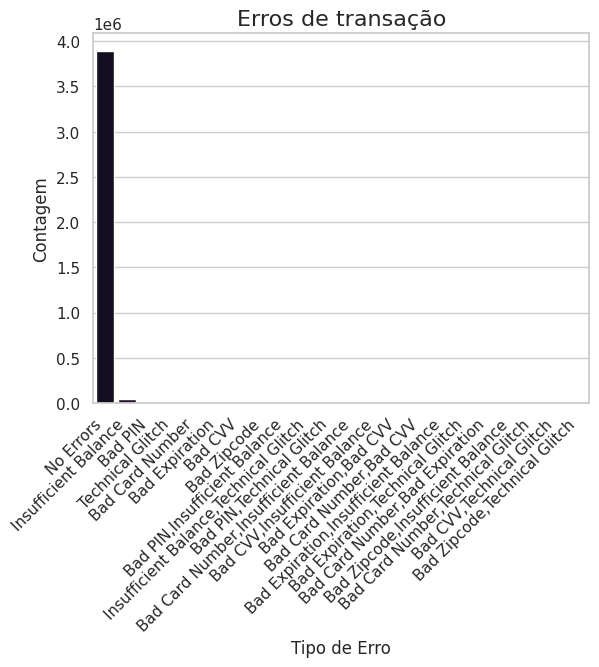

In [37]:
# Gráfico 01 - Distribuição das categorias de erro 

sns.barplot(
  x = error_counts.index,
  y = error_counts.values,
  palette='rocket'
)
plt.title("Erros de transação", fontsize=16)
plt.xlabel("Tipo de Erro", fontsize=12)
plt.ylabel("Contagem", fontsize=12)
plt.xticks(rotation=45, ha='right')

Text(0, 0.5, 'Contagem')

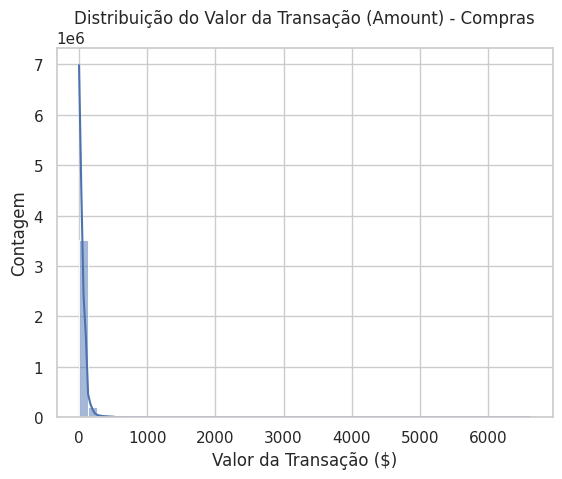

In [38]:
# Gráfico 02 - Distribuição da coluna 'amount' 

get = transactions_df[transactions_df['amount'] >= 0]

sns.histplot(
  get['amount'], 
  bins=50, 
  kde=True, 
  log_scale=False
)
plt.title("Distribuição do Valor da Transação (Amount) - Compras")
plt.xlabel("Valor da Transação ($)")
plt.ylabel("Contagem")

<Axes: xlabel='amount'>

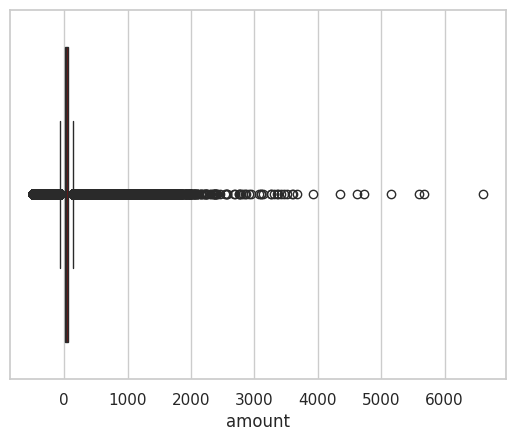

In [39]:
# Gráfico 03 - Identificando outliers e quartis

sns.boxplot(
  x = transactions_df['amount'],
  color='darkred'
)

In [7]:
# Removendo outliers da coluna 'amount'

Q1, Q3 = transactions_df['amount'].quantile(0.25), transactions_df['amount'].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR 

transactions_df = transactions_df[(transactions_df['amount'] >= lb) & (transactions_df['amount'] <= ub)]
transactions_df.shape

(3637703, 12)

<Axes: xlabel='amount'>

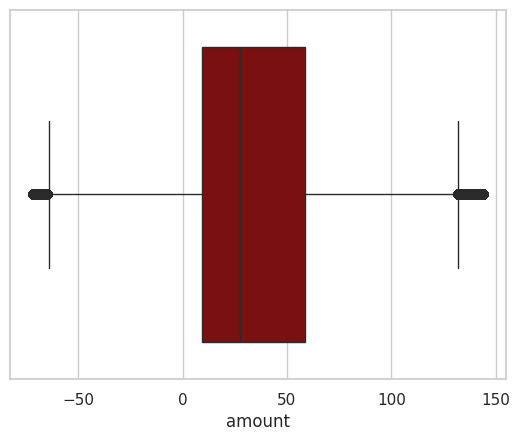

In [41]:
# Gráfico 04 - Amount removendo outliers 
sns.boxplot(
  x = transactions_df['amount'],
  color='darkred'
)

/tmp/ipykernel_13541/1518852570.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'ONLINE'),
  Text(1, 0, 'Houston'),
  Text(2, 0, 'Brooklyn'),
  Text(3, 0, 'Miami'),
  Text(4, 0, 'Los Angeles'),
  Text(5, 0, 'Dallas'),
  Text(6, 0, 'Chicago'),
  Text(7, 0, 'Louisville'),
  Text(8, 0, 'San Antonio'),
  Text(9, 0, 'Philadelphia')])

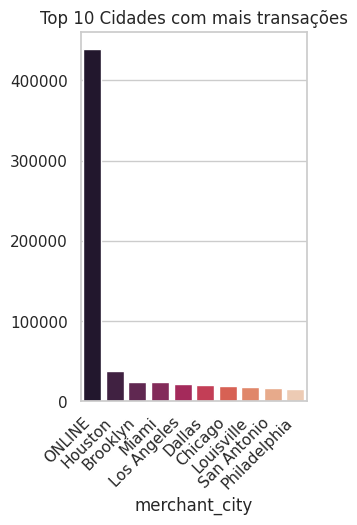

In [42]:
# Gráfico 05 - 10 locais com mais transações

top_places = transactions_df['merchant_city'].value_counts().head(10)
plt.subplot(1, 2, 1)
sns.barplot(
  x = top_places.index,
  y = top_places.values,
  palette="rocket"
)
plt.title("Top 10 Cidades com mais transações")
plt.xticks(rotation=45, ha='right')

/tmp/ipykernel_13541/1544921388.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'ONLINE'),
  Text(1, 0, 'CA'),
  Text(2, 0, 'TX'),
  Text(3, 0, 'NY'),
  Text(4, 0, 'FL'),
  Text(5, 0, 'OH'),
  Text(6, 0, 'IL'),
  Text(7, 0, 'NC'),
  Text(8, 0, 'PA'),
  Text(9, 0, 'MI')])

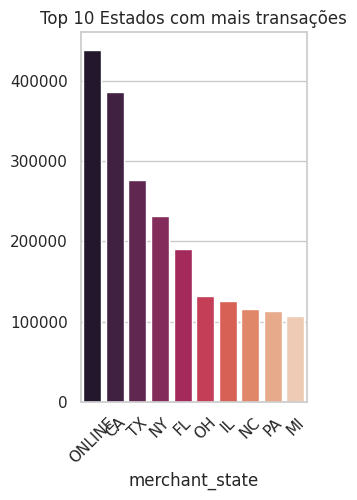

In [43]:
# Gráfico 06 - 10 estados com mais transações

top_states = transactions_df['merchant_state'].value_counts().head(10)
plt.subplot(1, 2, 2)
sns.barplot(
  x = top_states.index,
  y = top_states.values,
  palette="rocket"
)
plt.title("Top 10 Estados com mais transações")
plt.xticks(rotation=45)

KeyboardInterrupt: 

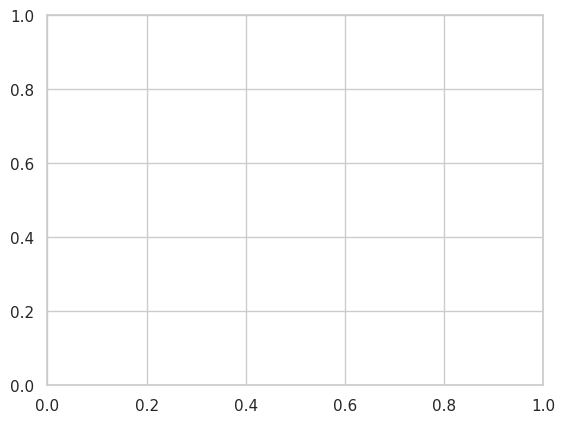

In [8]:
# Gráfico 7 - Valor da transação por tipo de uso do cartão
  
sns.boxplot(
  x='use_chip', 
  y='amount', 
  data=transactions_df, 
  palette="rocket"
)
    
plt.title("Distribuição do Valor (amount) vs. Tipo de Uso de Chip")
plt.xlabel("Tipo de Uso (Chip vs. Swipe etc.)")
plt.ylabel("Valor da Transação")

#### Análise de Dados - Cartões

In [45]:
data_analysis(cards_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (6146, 13)

Quantidade de dados: 6146
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pi

In [8]:
def transform_cards_df(df: pd.DataFrame) -> pd.DataFrame:
  df = clean_currency_column(df, 'credit_limit')

  df['expires'] = pd.to_datetime(df['expires'], format='%m/%Y', errors='coerce')
  df['acct_open_date'] = pd.to_datetime(df['acct_open_date'], format='%m/%Y', errors='coerce')
  print("  -> 'expires' e 'acct_open_date' convertidos para datetime.")

  string_cols = ['card_brand', 'card_type', 'has_chip', 'card_on_dark_web']
  df = convert_to_string(df, string_cols)

  df['cvv'] = df['cvv'].astype('int16')
  df['year_pin_last_changed'] = df['year_pin_last_changed'].astype('int16')

  return df

cards_df = transform_cards_df(cards_df)

  -> Limpando e convertendo a coluna de moeda: credit_limit
  -> 'expires' e 'acct_open_date' convertidos para datetime.
  -> Converteu 'card_brand' para 'string'.
  -> Converteu 'card_type' para 'string'.
  -> Converteu 'has_chip' para 'string'.
  -> Converteu 'card_on_dark_web' para 'string'.


In [47]:
data_analysis(cards_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (6146, 13)

Quantidade de dados: 6146
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     6146 non-null   int64         
 1   client_id              6146 non-null   int64         
 2   card_brand             6146 non-null   string        
 3   card_type              6146 non-null   string        
 4   card_number            6146 non-null   int64         
 5   expires                6146 non-null   datetime64[ns]
 6   cvv                    6146 non-null   int16         
 7   has_chip               6146 non-null   string        
 8   num_cards_issued       6146 non-null   int64         
 9   credit_limit         

/tmp/ipykernel_13541/2150750438.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Contagem de cartões')

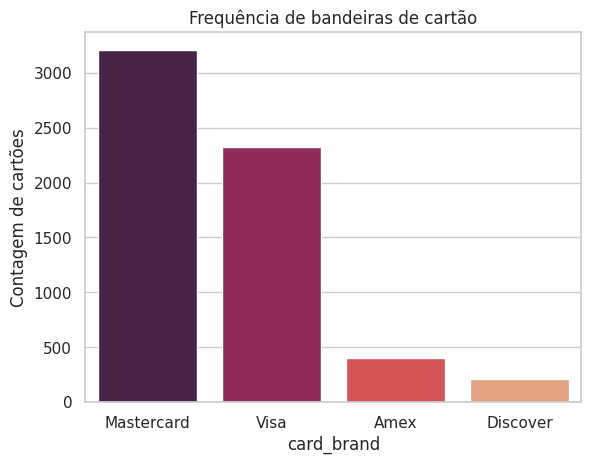

In [48]:
# Gráfico 01 - Frequência de bandeiras de cartão 

brand_counts = cards_df['card_brand'].value_counts()
sns.barplot(
  x = brand_counts.index,
  y = brand_counts.values, 
  palette="rocket"
)
plt.title("Frequência de bandeiras de cartão")
plt.ylabel("Contagem de cartões")

/tmp/ipykernel_13541/1213168474.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Contagem de Cartões')

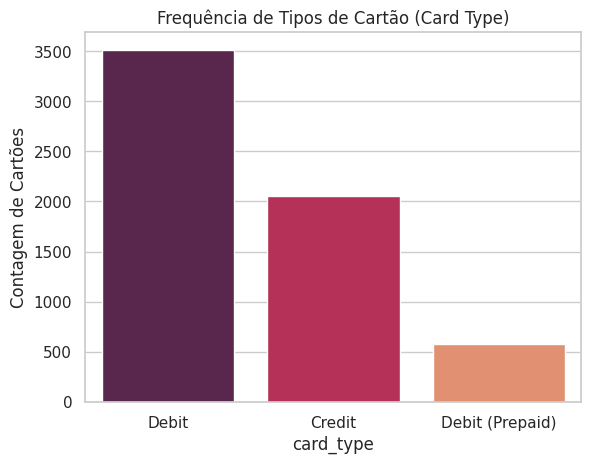

In [49]:
# Gráfico 02 - Frequência de tipos de cartão

type_counts = cards_df['card_type'].value_counts()
sns.barplot(
  x = type_counts.index,
  y = type_counts.values,
  palette='rocket'
)
plt.title("Frequência de Tipos de Cartão (Card Type)")
plt.ylabel("Contagem de Cartões")

/tmp/ipykernel_13541/3368631909.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


(array([2000. , 2002.5, 2005. , 2007.5, 2010. , 2012.5, 2015. , 2017.5,
        2020. , 2022.5]),
 [Text(2000.0, 0, '2000.0'),
  Text(2002.5, 0, '2002.5'),
  Text(2005.0, 0, '2005.0'),
  Text(2007.5, 0, '2007.5'),
  Text(2010.0, 0, '2010.0'),
  Text(2012.5, 0, '2012.5'),
  Text(2015.0, 0, '2015.0'),
  Text(2017.5, 0, '2017.5'),
  Text(2020.0, 0, '2020.0'),
  Text(2022.5, 0, '2022.5')])

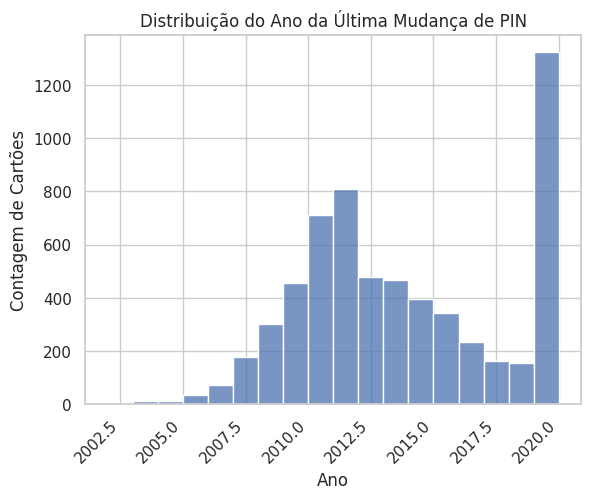

In [50]:
# Gráfico 03 - Distribuição do ano da última mudança de pin
sns.histplot(
  cards_df['year_pin_last_changed'], 
  bins=np.arange(cards_df['year_pin_last_changed'].min(), 
  cards_df['year_pin_last_changed'].max() + 1, 1), 
  kde=False, 
  palette='rocket'
)

plt.title("Distribuição do Ano da Última Mudança de PIN")
plt.xlabel("Ano")
plt.ylabel("Contagem de Cartões")
plt.xticks(rotation=45, ha='right')

/tmp/ipykernel_13541/1653418019.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


Text(0, 0.5, 'Contagem de Cartões')

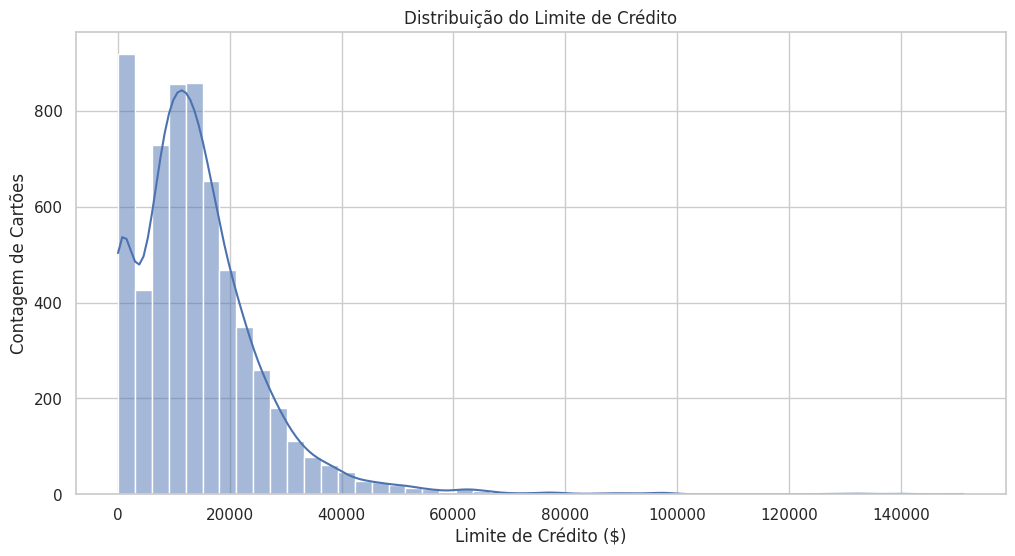

In [51]:
# Gráfico 04: Distribuição do Limite de Crédito
limit_numeric = cards_df['credit_limit'] \
  .astype(str).str.replace(r'[^\d\.]', '', regex=True).astype(float)
    
plt.figure(figsize=(12, 6))
    
sns.histplot(
  limit_numeric, 
  bins=50, 
  kde=True, 
  log_scale=False, 
  palette='rocket'
)
    
plt.title("Distribuição do Limite de Crédito")
plt.xlabel("Limite de Crédito ($)")
plt.ylabel("Contagem de Cartões")

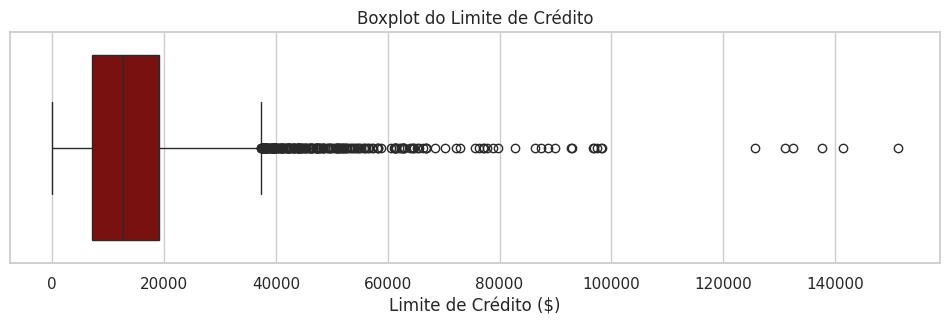

In [52]:
# Gráfico 05: Boxplot para média e outliers do limite de crédito

plt.figure(figsize=(12, 3))
sns.boxplot(x=limit_numeric, color='darkred')
plt.title("Boxplot do Limite de Crédito")
plt.xlabel("Limite de Crédito ($)")
plt.show()

In [9]:
Q1, Q3 = cards_df['credit_limit'].quantile(0.25), cards_df['credit_limit'].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR 
ub = Q3 + 1.5 * IQR 
cards_df = cards_df[(cards_df['credit_limit'] >= lb) & (cards_df['credit_limit'] <= ub)]
cards_df.shape 

(5911, 13)

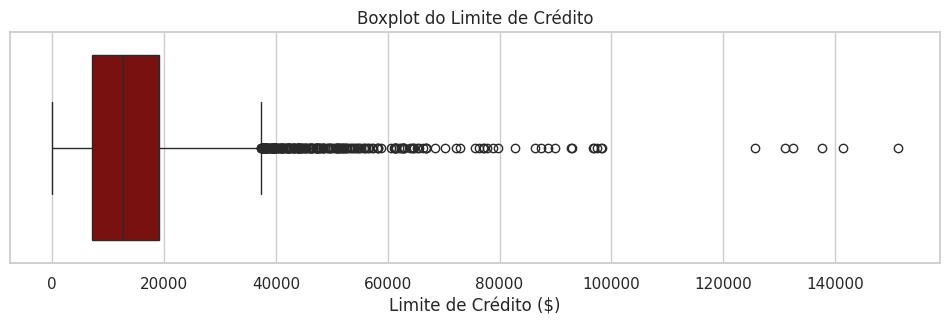

In [54]:
# Gráfico 06: Boxplot com retirada de outliers

plt.figure(figsize=(12, 3))
sns.boxplot(x=limit_numeric, color='darkred')
plt.title("Boxplot do Limite de Crédito")
plt.xlabel("Limite de Crédito ($)")
plt.show()

/tmp/ipykernel_13541/3601577318.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


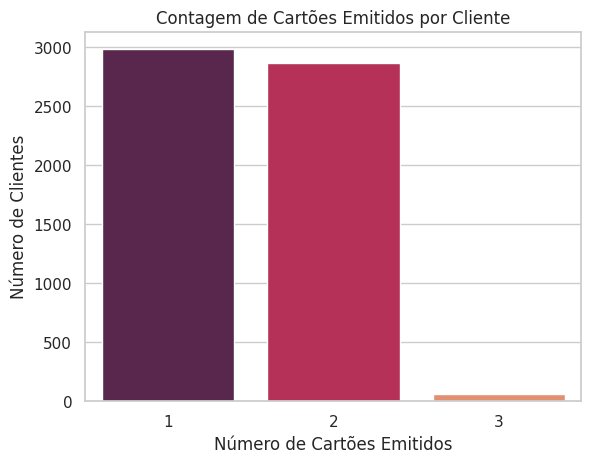

In [55]:
# Gráfico 07 - Contagem de cartões por clientes

num_cards_counts = cards_df['num_cards_issued'].value_counts().sort_index()

sns.barplot(
  x=num_cards_counts.index, 
  y=num_cards_counts.values, 
  palette="rocket"
)
plt.title("Contagem de Cartões Emitidos por Cliente")
plt.xlabel("Número de Cartões Emitidos")
plt.ylabel("Número de Clientes")
plt.show()

Correlação de Pearson entre Limite de Crédito e Nº de Cartões: -0.0985


/tmp/ipykernel_13541/2808379616.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


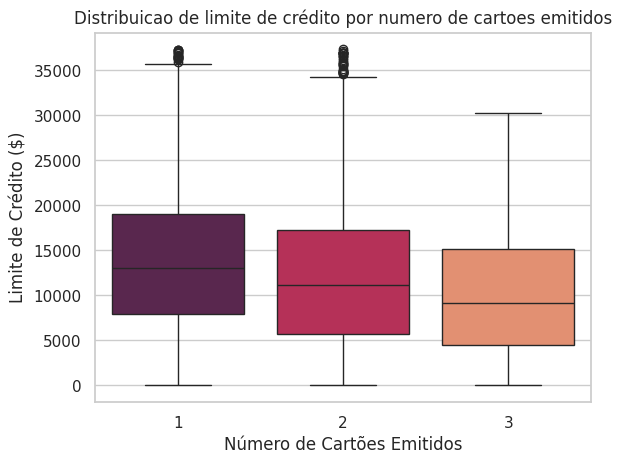

In [56]:
sns.boxplot(
    x='num_cards_issued', 
    y='credit_limit', 
    data=cards_df, 
    palette='rocket'
)
plt.title("Distribuicao de limite de crédito por numero de cartoes emitidos")
plt.xlabel("Número de Cartões Emitidos")
plt.ylabel("Limite de Crédito ($)")

correlation = cards_df['num_cards_issued'].corr(cards_df['credit_limit'])
print(f"Correlação de Pearson entre Limite de Crédito e Nº de Cartões: {correlation:.4f}")

#### Análise de Dados - Usuários

In [57]:
data_analysis(users_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (2000, 14)

Quantidade de dados: 2000
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12

In [10]:
def transform_users_df(df: pd.DataFrame) -> pd.DataFrame:
  df = clean_currency_column(df, 'per_capita_income')
  df = clean_currency_column(df, 'yearly_income')
  df = clean_currency_column(df, 'total_debt')
  string_cols = ['gender', 'address']
  df = convert_to_string(df, string_cols)
  df['retirement_age'] = df['retirement_age'].astype('int16')
  df['current_age'] = df['current_age'].astype('int16')
  return df
users_df = transform_users_df(users_df)

  -> Limpando e convertendo a coluna de moeda: per_capita_income
  -> Limpando e convertendo a coluna de moeda: yearly_income
  -> Limpando e convertendo a coluna de moeda: total_debt
  -> Converteu 'gender' para 'string'.
  -> Converteu 'address' para 'string'.


In [59]:
data_analysis(users_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (2000, 14)

Quantidade de dados: 2000
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int16  
 2   retirement_age     2000 non-null   int16  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   string 
 6   address            2000 non-null   string 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   int64  
 10  yearly_income      2000 non-null   int64  
 11  total_debt         2000 non-null   int64  
 12

Text(0, 0.5, 'Contagem de Clientes')

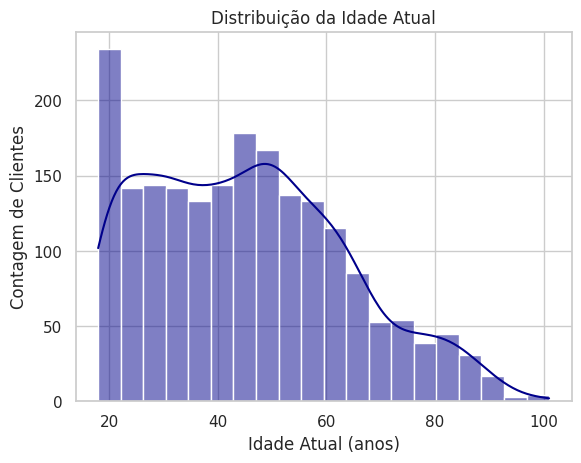

In [60]:
# Gráfico 01 - Distribuição de idades

sns.histplot(
  users_df['current_age'], 
  bins=20, 
  kde=True, 
  color='darkblue'
)
plt.title("Distribuição da Idade Atual")
plt.xlabel("Idade Atual (anos)")
plt.ylabel("Contagem de Clientes")

Text(0, 0.5, 'Contagem de Clientes')

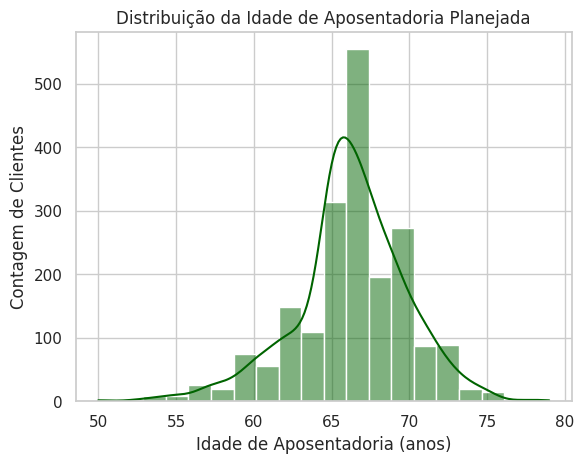

In [61]:
# Gráfico 02 - Distribuição de idade de aposentadoria planejada
sns.histplot(
  users_df['retirement_age'], 
  bins=20, 
  kde=True, 
  color='darkgreen'
)
plt.title("Distribuição da Idade de Aposentadoria Planejada")
plt.xlabel("Idade de Aposentadoria (anos)")
plt.ylabel("Contagem de Clientes")

/tmp/ipykernel_13541/154816515.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


(0.0, 231627.87)

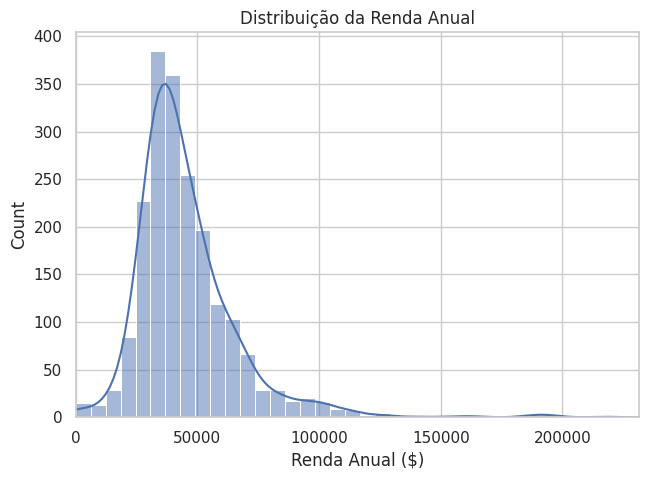

In [62]:
# Gráfico 03 - Distribuição de renda e dívida
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
sns.histplot(
  users_df['yearly_income'], 
  bins=50, 
  kde=True, 
  palette='rocket'
)
plt.title("Distribuição da Renda Anual")
plt.xlabel("Renda Anual ($)")
plt.xlim(0, users_df['total_debt'].quantile(0.99))

/tmp/ipykernel_13541/2656460663.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(users_df['total_debt'], bins=50, kde=True, palette='rocket')


(0.0, 231627.87)

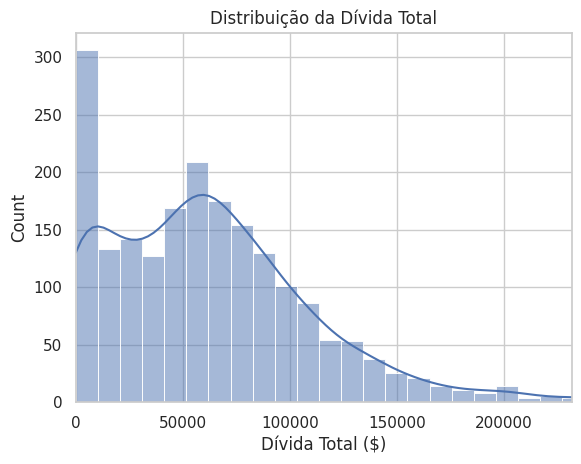

In [63]:
# Gráfico 04 - Distribuição da dívida
sns.histplot(users_df['total_debt'], bins=50, kde=True, palette='rocket')
plt.title("Distribuição da Dívida Total")
plt.xlabel("Dívida Total ($)")
plt.xlim(0, users_df['total_debt'].quantile(0.99))

/tmp/ipykernel_13541/3114010318.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Text(0, 0.5, 'Pontuação de Crédito (Credit Score)')

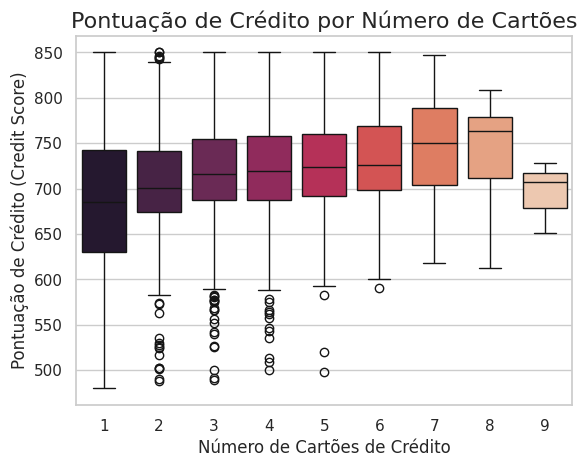

In [64]:
# Gráfico 05 - Pontuação de crédito por número de cartões

sns.boxplot(
  x=users_df['num_credit_cards'], 
  y=users_df['credit_score'], 
  palette="rocket"
)
plt.title("Pontuação de Crédito por Número de Cartões", fontsize=16)
plt.xlabel("Número de Cartões de Crédito", fontsize=12)
plt.ylabel("Pontuação de Crédito (Credit Score)", fontsize=12)

In [11]:
cols = [
  'current_age',
  'retirement_age',
  'per_capita_income',
  'yearly_income',
  'total_debt',
  'credit_score',
  'num_credit_cards'
]

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'current_age'),
  Text(1, 0, 'retirement_age'),
  Text(2, 0, 'per_capita_income'),
  Text(3, 0, 'yearly_income'),
  Text(4, 0, 'total_debt'),
  Text(5, 0, 'credit_score'),
  Text(6, 0, 'num_credit_cards')])

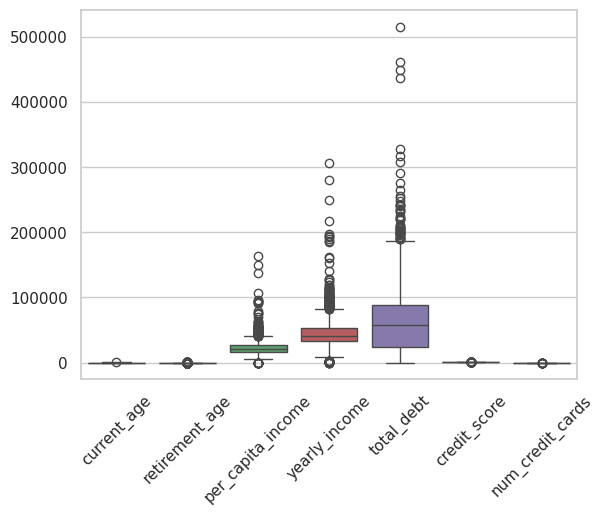

In [ ]:
# Grafico 06 - Analise geral dos outliers

sns.boxplot(
  users_df[cols]
)
plt.xticks(rotation=45)

In [12]:
# Removendo os outliers
for col in cols:
  Q1, Q3 = users_df[col].quantile(0.25), users_df[col].quantile(0.75)
  IQR = Q3 - Q1 
  lb = Q1 - 1.5 * IQR 
  lb = max(0, lb)
  
  ub = Q3 + 1.5 * IQR 

  users_df = users_df[(users_df[col] >= lb) & (users_df[col] <= ub)]

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'current_age'),
  Text(1, 0, 'retirement_age'),
  Text(2, 0, 'per_capita_income'),
  Text(3, 0, 'yearly_income'),
  Text(4, 0, 'total_debt'),
  Text(5, 0, 'credit_score'),
  Text(6, 0, 'num_credit_cards')])

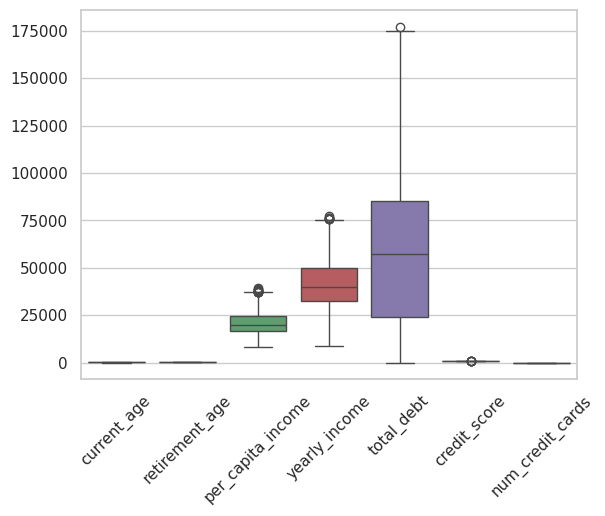

In [67]:
# Grafico 07 - Analise pos remocao de outliers

sns.boxplot(
  users_df[cols]
)
plt.xticks(rotation=45)

/tmp/ipykernel_13541/690530200.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


Text(0, 0.5, 'Latitude')

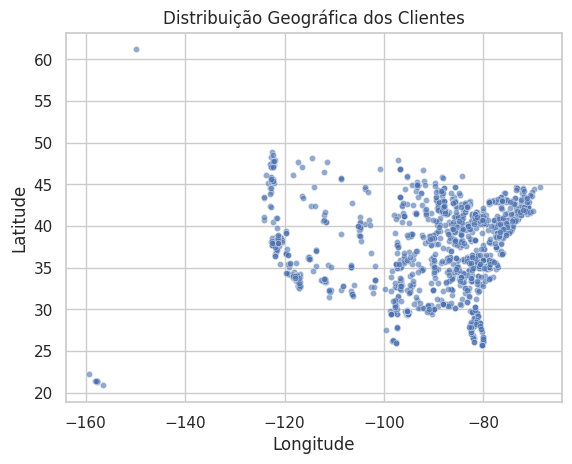

In [68]:
# Gráfico 08 - Distribuição geográfica de clientes
sns.scatterplot(
  x=users_df['longitude'], 
  y=users_df['latitude'], 
  s=20, 
  alpha=0.6, 
  palette='rocket'
)
plt.title("Distribuição Geográfica dos Clientes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


<Axes: xlabel='yearly_income', ylabel='total_debt'>

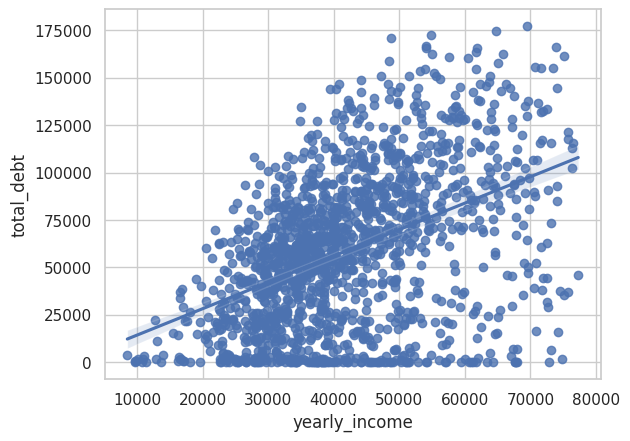

In [69]:
# Grafico 09 - Ganhos anuais por divida total

sns.regplot(
  x = users_df['yearly_income'],
  y = users_df['total_debt'],
)

<Axes: xlabel='yearly_income', ylabel='Count'>

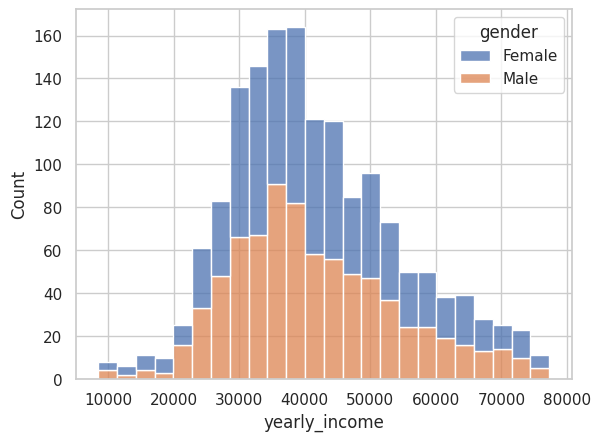

In [70]:
# Grafico 10 - Ganhos anuais por genero 

sns.histplot(
  x = users_df['yearly_income'],
  hue=users_df['gender'],
  multiple='stack'
)

#### Análise de Dados - Códigos de mercantes

In [13]:
mcc_df = mcc_df.reset_index()
mcc_df.columns = ['mcc_code', "description"]

In [ ]:
data_analysis(mcc_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (109, 2)

Quantidade de dados: 109
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mcc_code     109 non-null    int64 
 1   description  109 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.0 KB
---------------------------------------------

Estatísticas descritivas:
           mcc_code         description
count    109.000000                 109
unique          NaN                 108
top             NaN  Passenger Railways
freq            NaN                   2
mean    5311.165138                 NaN
std     1747.760406                 NaN
min     1711.000000                 NaN
25%     3684.000000                 NaN
50%     5310.000000                

In [72]:
mcc_df.head()

,mcc_code,description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


/tmp/ipykernel_13541/3463762960.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


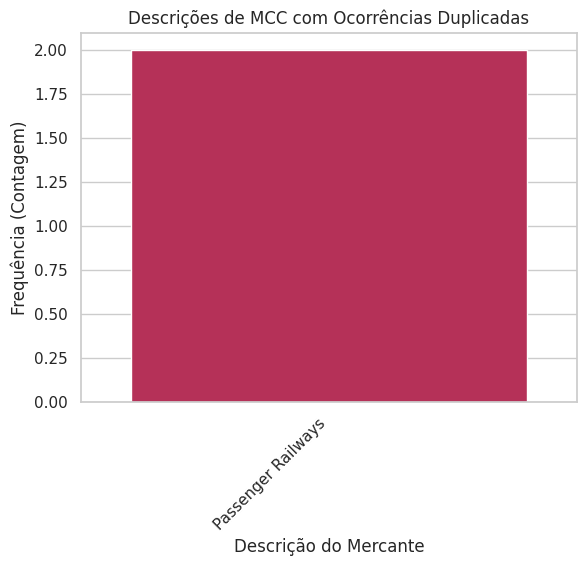

In [73]:
# Gráfico 01 

description_counts = mcc_df['description'].value_counts()

duplicate_descriptions = description_counts[description_counts > 1]

if not duplicate_descriptions.empty:
    sns.barplot(
        x=duplicate_descriptions.index, 
        y=duplicate_descriptions.values, 
        palette="rocket"
    )
    plt.title("Descrições de MCC com Ocorrências Duplicadas")
    plt.xlabel("Descrição do Mercante")
    plt.ylabel("Frequência (Contagem)")
    plt.xticks(rotation=45, ha='right')
else:
    print("AVISO: Nenhuma descrição de mercante aparece mais de uma vez no conjunto de dados.")

In [14]:
print(f"Linhas antes da limpeza: {mcc_df.shape[0]}")
duplicate_rows = mcc_df[mcc_df['description'].duplicated(keep=False)]

print("\n--- DETALHES DAS LINHAS DUPLICADAS ('Passenger Railways') ---")
print(duplicate_rows)

mcc_df_unique = mcc_df.drop_duplicates(subset=['description'], keep='first').copy()

linhas_removidas = mcc_df.shape[0] - mcc_df_unique.shape[0]
print(f"\nLinhas removidas: {linhas_removidas}")
print(f"Novo tamanho do mcc_df: {mcc_df_unique.shape[0]}")

mcc_df = mcc_df_unique 

Linhas antes da limpeza: 109

--- DETALHES DAS LINHAS DUPLICADAS ('Passenger Railways') ---
    mcc_code         description
33      3722  Passenger Railways
79      4112  Passenger Railways

Linhas removidas: 1
Novo tamanho do mcc_df: 108


In [ ]:
description_counts = mcc_df['description'].value_counts()
duplicate_descriptions = description_counts[description_counts > 1]

if not duplicate_descriptions.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=duplicate_descriptions.index, 
        y=duplicate_descriptions.values, 
        palette="rocket"
    )
    plt.title("Descrições de MCC com Ocorrências Duplicadas (Pós-Limpeza)")
    plt.xlabel("Descrição do Mercante")
    plt.ylabel("Frequência (Contagem)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nSUCESSO: Nenhuma descrição duplicada restante. O mcc_df está limpo.")

Text(0, 0.5, 'Contagem de Códigos')

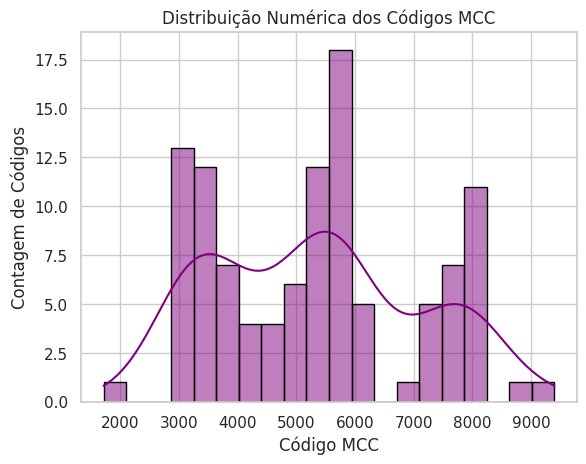

In [75]:
# Gráfico 02 
sns.histplot(
  mcc_df['mcc_code'], 
  bins=20, 
  kde=True, 
  color='purple', 
  edgecolor='black'
)
    
plt.title("Distribuição Numérica dos Códigos MCC")
plt.xlabel("Código MCC")
plt.ylabel("Contagem de Códigos")

#### Análise de Dados - Fraudes com etiqueta

In [15]:
fraud_df = fraud_df.reset_index()
fraud_df.columns = ['id', "target"]

In [ ]:
data_analysis(fraud_df)

ANÁLISE DE DADOS DO DATAFRAME
---------------------------------------------

Quantidade de linhas e colunas: (8914963, 2)

Quantidade de dados: 8914963
---------------------------------------------

Informações detalhadas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   target  object
dtypes: int64(1), object(1)
memory usage: 501.6 MB
---------------------------------------------

Estatísticas descritivas:
                  id   target
count   8.914963e+06  8914963
unique           NaN        2
top              NaN       No
freq             NaN  8901631
mean    1.558473e+07      NaN
std     4.703991e+06      NaN
min     7.475327e+06      NaN
25%     1.150786e+07      NaN
50%     1.557140e+07      NaN
75%     1.965387e+07      NaN
max     2.376187e+07      NaN
---------------------------------------------

Contagem de nulos:
        Nulos
id          0
target 

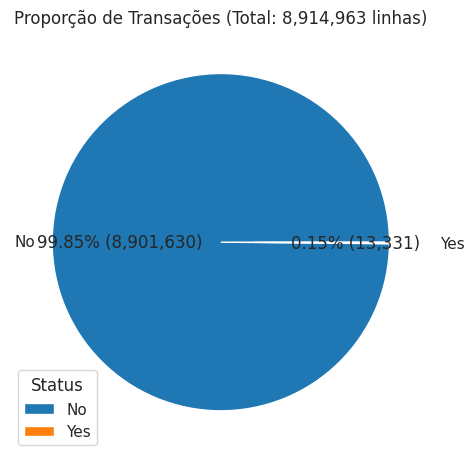

--------------------------------------------------
Total de Fraudes ('Yes'): 13,332
Porcentagem de Fraude: 0.1495%
--------------------------------------------------


In [77]:
# Gráfico 1: Desbalanceamento de Classes (Fraude vs. Não Fraude)
target_counts = fraud_df['target'].value_counts()

total = target_counts.sum()
percentages = (target_counts / total) * 100

plt.pie(target_counts, 
        labels=target_counts.index, 
        autopct=lambda p: f'{p:.2f}% ({int(p*total/100):,})', 
        colors=['#1f77b4', '#ff7f0e'],
        explode=[0, 0.2] 
       )

plt.title(f"Proporção de Transações (Total: {total:,} linhas)")
plt.legend(loc='lower left', title="Status")
plt.tight_layout()
plt.show()

print("-" * 50)
print(f"Total de Fraudes ('Yes'): {target_counts.get('Yes', 0):,}")
print(f"Porcentagem de Fraude: {percentages.get('Yes', 0):.4f}%")
print("-" * 50)

/tmp/ipykernel_13541/360578951.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


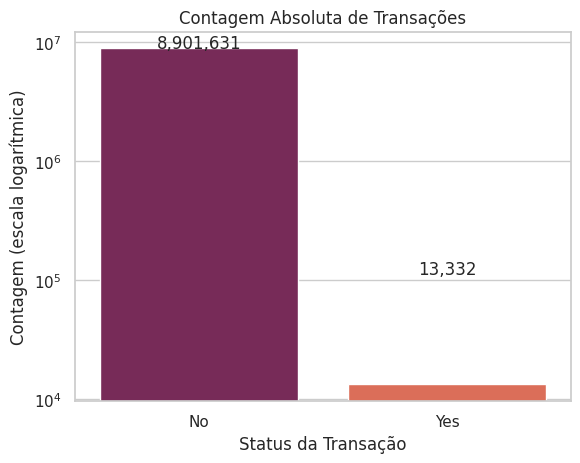

In [78]:
# Gráfico 2: Frequência Simples da Classe Minoritária
sns.barplot(
  x=target_counts.index, 
  y=target_counts.values, 
  palette='rocket'
)

plt.title("Contagem Absoluta de Transações")
plt.xlabel("Status da Transação")
plt.ylabel("Contagem (escala logarítmica)")
plt.yscale('log') 

for i, count in enumerate(target_counts.values):
    plt.text(i, count + 100000, f'{count:,}', ha='center')

#### Agregando todos os DataFrames 

In [79]:
# Colunas DataFrame transactions
print("Colunas do transactions_df (Esquerda):")
print(transactions_df.columns.tolist())

# Colunas DataFrame cards
print("\nColunas do cards_df:")
print(cards_df.columns.tolist())

# Colunas DataFrame users
print("\nColunas do users_df:")
print(users_df.columns.tolist())

# Colunas DataFrame mcc
print("\nColunas do mcc_df:")
print(mcc_df.columns.tolist())

# Colunas DataFrame fraud
print("\nColunas do fraud_df:")
print(fraud_df.columns.tolist())

Colunas do transactions_df (Esquerda):
['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors']

Colunas do cards_df:
['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web']

Colunas do users_df:
['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender', 'address', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards']

Colunas do mcc_df:
['mcc_code', 'description']

Colunas do fraud_df:
['id', 'target']


In [16]:
# Renomeando colunas para o merge
cards_df = cards_df.rename(columns={'id': 'card_id'})
users_df = users_df.rename(columns={'id': 'client_id'})
fraud_df = fraud_df.rename(columns={'id': 'transaction_id', 'target': 'is_fraud'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})
mcc_df = mcc_df.rename(columns={"mcc_code": "mcc"})

In [17]:
# 1. MERGE: Transações (Fato) + Cartões (Dimensão)
merged_tc = pd.merge(
    left=transactions_df,
    right=cards_df,
    how='left',
    on='card_id',  # Chave padronizada
    suffixes=('_tran', "_card")
)

merged_tc = merged_tc.drop(columns=['client_id_card'])
merged_tc = merged_tc.rename(columns={'client_id_tran': 'client_id'})

print(f"1/4: Merge Transações + Cartões concluído. Colunas: {merged_tc.shape[1]}")

1/4: Merge Transações + Cartões concluído. Colunas: 23


In [18]:
# 2. MERGE: Tabela Intermediária + Usuários (Dimensão)
merged_tcu = pd.merge(
    left=merged_tc,
    right=users_df,
    how='left',
    on='client_id', # Chave padronizada
    suffixes=('_base', "_user")
)
print(f"2/4: Merge com Usuários concluído. Colunas: {merged_tcu.shape[1]}")

2/4: Merge com Usuários concluído. Colunas: 36


In [19]:
# 3. MERGE: Tabela Intermediária + MCC (Dimensão)
# Assumindo que a coluna MCC no transactions_df é 'mcc'
df_tcum = pd.merge(
    left=merged_tcu,
    right=mcc_df,
    how='left',
    on='mcc',
    suffixes=('_base', '_mcc')
)
# Renomeação da descrição MCC
if 'description' in df_tcum.columns:
    df_tcum = df_tcum.rename(columns={'description': 'mcc_description'})

print(f"3/4: Merge com MCC concluído. Colunas: {df_tcum.shape[1]}")

3/4: Merge com MCC concluído. Colunas: 37


In [20]:
# 4. MERGE: Tabela Fato Completa + Rótulos de Fraude
df_final = pd.merge(
    left=df_tcum,
    right=fraud_df[['transaction_id', 'is_fraud']], 
    how='left',
    on='transaction_id', # Chave padronizada
    suffixes=('_base', '_fraud')
)

print("\n--- Tabela Única Finalizada! ---")
print(f"Total de linhas na Tabela Única: {len(df_final)}")
print(f"Total de colunas: {len(df_final.columns)}")


--- Tabela Única Finalizada! ---
Total de linhas na Tabela Única: 3637703
Total de colunas: 38


In [21]:
import pandas as pd
import os

def generate_sql_csv(df: pd.DataFrame, table_name: str) -> str:
    """
    Gera o script DDL SQL CREATE TABLE para PostgreSQL (sem PRIMARY KEY) 
    aplicando otimização de tipos e exporta o DataFrame final para CSV e SQL.
    """
    dtype_mapping = {
        'transaction_id': 'BIGINT', 
        'client_id': 'BIGINT',
        'card_id': 'BIGINT',
        'mcc': 'SMALLINT', 
        'zip': 'INTEGER',
        'cvv': 'INTEGER',
        'num_cards_issued': 'SMALLINT',
        'current_age': 'SMALLINT',
        'retirement_age': 'SMALLINT',
        'num_credit_cards': 'SMALLINT',
        'birth_year': 'SMALLINT',
        'birth_month': 'SMALLINT',
        'amount': 'NUMERIC(10, 2)', 
        'credit_limit': 'NUMERIC(10, 2)',
        'yearly_income': 'NUMERIC(12, 2)',
        'total_debt': 'NUMERIC(12, 2)',
        'per_capita_income': 'NUMERIC(12, 2)',
        'latitude': 'NUMERIC(9, 6)',
        'longitude': 'NUMERIC(9, 6)',
        'credit_score': 'SMALLINT',
        'is_fraud': 'SMALLINT', 
        'date': 'TIMESTAMP',
        'expires': 'TIMESTAMP',
        'acct_open_date': 'TIMESTAMP',
        'object': 'VARCHAR(255)', 
        'string': 'VARCHAR(255)'
    }

    schema = []
    
    for column, dtype in df.dtypes.items():
        clean_column = column.lower().replace('-', '_').replace('$', 'limit').replace(' ', '_')
        
        sql_type = dtype_mapping.get(clean_column) 
        
        if sql_type is None:
            sql_type = dtype_mapping.get(str(dtype), 'VARCHAR(255)') 
        
        not_null = " NOT NULL" if clean_column in ['client_id', 'amount', 'date', 'mcc', 'transaction_id'] else ""
        
        if not (clean_column.endswith('_card') or clean_column.endswith('_user') or 
                clean_column in ['client_id_card', 'client_id_tran', 'id_card', 'id_user', 'id_mcc']):
            schema.append(f"{clean_column} {sql_type}{not_null}")

    ddl = f"CREATE TABLE IF NOT EXISTS {table_name.lower()} (\n\t"
    ddl += ",\n\t".join(schema)
    ddl += "\n);"
    
    output_filename_csv = f"{table_name.lower()}.csv"
    try:
        df.to_csv(output_filename_csv, index=False)
        print(f"\n[DELIVERY] Arquivo CSV salvo com sucesso: {output_filename_csv}")
    except Exception as e:
        print(f"\nERRO ao salvar o CSV: {e}")

    output_filename_sql = f"../../Transformer/scripts/{table_name.lower()}_ddl.sql"
    try:
        os.makedirs(os.path.dirname(output_filename_sql), exist_ok=True)
        with open(output_filename_sql, 'w') as f:
            f.write(ddl)
        print(f"[DELIVERY] DDL SQL salvo com sucesso: {output_filename_sql}")
    except Exception as e:
        print(f"\nERRO ao salvar o script DDL no caminho especificado: {e}")

    return ddl

table_name = "transactions_cards_users_mcc_fraud"
ddl_script = generate_sql_csv(df_final, table_name)

print("\n" + "="*50)
print("--- SCRIPT DDL SQL GERADO PARA POSTGRESQL (Sem PK) ---")
print("="*50)
print(ddl_script)


[DELIVERY] Arquivo CSV salvo com sucesso: transactions_cards_users_mcc_fraud.csv
[DELIVERY] DDL SQL salvo com sucesso: ../../Transformer/scripts/transactions_cards_users_mcc_fraud_ddl.sql

--- SCRIPT DDL SQL GERADO PARA POSTGRESQL (Sem PK) ---
CREATE TABLE IF NOT EXISTS transactions_cards_users_mcc_fraud (
	transaction_id BIGINT NOT NULL,
	date TIMESTAMP NOT NULL,
	client_id BIGINT NOT NULL,
	card_id BIGINT,
	amount NUMERIC(10, 2) NOT NULL,
	use_chip VARCHAR(255),
	merchant_id VARCHAR(255),
	merchant_city VARCHAR(255),
	merchant_state VARCHAR(255),
	zip INTEGER,
	mcc SMALLINT NOT NULL,
	errors VARCHAR(255),
	card_brand VARCHAR(255),
	card_type VARCHAR(255),
	card_number VARCHAR(255),
	expires TIMESTAMP,
	cvv INTEGER,
	has_chip VARCHAR(255),
	num_cards_issued SMALLINT,
	credit_limit NUMERIC(10, 2),
	acct_open_date TIMESTAMP,
	year_pin_last_changed VARCHAR(255),
	card_on_dark_web VARCHAR(255),
	current_age SMALLINT,
	retirement_age SMALLINT,
	birth_year SMALLINT,
	birth_month SMALLINT,


In [91]:
df_final.dtypes

transaction_id                    int64
date                     datetime64[ns]
client_id                         int64
card_id                           int64
amount                          float64
use_chip                 string[python]
merchant_id                       int64
merchant_city            string[python]
merchant_state           string[python]
zip                             float64
mcc                               int64
errors                   string[python]
card_brand               string[python]
card_type                string[python]
card_number                     float64
expires                  datetime64[ns]
cvv                             float64
has_chip                 string[python]
num_cards_issued                float64
credit_limit                    float64
acct_open_date           datetime64[ns]
year_pin_last_changed           float64
card_on_dark_web         string[python]
current_age                     float64
retirement_age                  float64
